Loading Libraries

In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd  # import pandas library and give it an alias of pd
from scipy.stats import norm, kurtosis
import seaborn as sns
import math
import plotly.express as px

## Preparing Consolidated Sales Data

Importing Sales Data

In [2]:
sales1 = pd.read_excel ('Data/Labelmaster Sales Data.xlsx',sheet_name=0)
sales2 = pd.read_excel ('Data/Labelmaster Sales Data.xlsx',sheet_name=1)

Merging Sales Data

In [3]:
sales = pd.concat([sales1,sales2])

Working towards new primary key Customer_time. This will be treated as a single observation

In [1159]:
sales["customer_time"] = sales["Customer No"].astype(str) + sales["Posting Date"].astype(str)

Filtering customers having customer no empty or blank

In [1160]:
sales = sales[sales['Customer No'].apply(len) == 7]

Consolidating the data transaction wise (Based on customer_time)

In [164]:
sales_consolidated = sales.groupby(['customer_time'])['Quantity Ordered','Line Item Amount'].sum().reset_index()
sales_consolidated1 = sales.groupby(['customer_time'])['Quantity Ordered','Line Item Amount'].sum().reset_index()

C:\Users\areeb\AppData\Local\Temp/ipykernel_20280/3511125281.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sales_consolidated = sales.groupby(['customer_time'])['Quantity Ordered','Line Item Amount'].sum().reset_index()


In [217]:
sales_consolidated1['Customer No'] = sales_consolidated1['customer_time'].str[:7]
sales_consolidated1['Posting Date'] = sales_consolidated1['customer_time'].str[7:]
sales_consolidated['Customer No'] = sales_consolidated['customer_time'].str[:7]
sales_consolidated['Posting Date'] = sales_consolidated['customer_time'].str[7:]


Bringing next order/transaction date against the existing transaction

In [166]:
sales_consolidated.loc[sales_consolidated['Customer No'] == sales_consolidated['Customer No'].shift(-1),'next_order_date'] = sales_consolidated['Posting Date'].shift(-1) 
sales_consolidated.loc[sales_consolidated['next_order_date'].isnull(),'next_order_date'] = pd.to_datetime('today')

sales_consolidated['next_order_date'] = pd.to_datetime(sales_consolidated['next_order_date'])
sales_consolidated['Posting Date']=pd.to_datetime(sales_consolidated['Posting Date'])

#Computing time to order in days

sales_consolidated['time_to_order'] = sales_consolidated['next_order_date'] - sales_consolidated['Posting Date']
sales_consolidated['time_to_order'] = sales_consolidated['time_to_order']/np.timedelta64(1,'D')

#Forcing the minimum order time to be 30 days
sales_consolidated.loc[sales_consolidated['time_to_order'] < 30,'time_to_order'] = 30

Assigning each customer an ID and counting the number of transactions for each customer 

In [171]:
sales_consolidated['block'] = (sales_consolidated['Customer No'] != sales_consolidated['Customer No'].shift(1)).astype(int).cumsum()
sales_consolidated['count'] = sales_consolidated.groupby((sales_consolidated['Customer No'] != sales_consolidated['Customer No'].shift(1)).cumsum()).cumcount()+1

Computing expected purchase window for each customer

In [173]:
sales_consolidated['cumulative_sum_time'] = sales_consolidated.groupby('Customer No')['time_to_order'].cumsum()
sales_consolidated.loc[sales_consolidated['Customer No'] == sales_consolidated['Customer No'].shift(1),'cumulative_sum_time_shifted'] = sales_consolidated['cumulative_sum_time'].shift(1) 
sales_consolidated.loc[sales_consolidated['Customer No'] == sales_consolidated['Customer No'].shift(1),'count_shifted'] = sales_consolidated['count'].shift(1) 
sales_consolidated.loc[sales_consolidated['count'] > 1, 'expected_purchase_window'] = sales_consolidated['cumulative_sum_time_shifted']/sales_consolidated['count_shifted']
sales_consolidated.drop(['cumulative_sum_time', 'cumulative_sum_time_shifted','count_shifted'], axis=1, inplace=True)

Checking the distribution of expected purchase time between the first and second sale for all customers. 

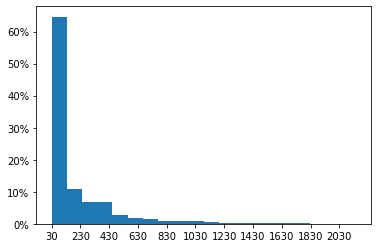

In [179]:
s = sales_consolidated.loc[sales_consolidated['count'] == 2]['expected_purchase_window']
from matplotlib.ticker import PercentFormatter
plt.hist(s, weights=np.ones(len(s)) / len(s), bins = 20)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(np.arange(min(s), max(s), 200))
plt.show()

60-70% of customers take less than 100 days between their 1st and 2nd sale

Setting expected purchase window = 60 for the first transaction based on the graph above

In [178]:
sales_consolidated.loc[sales_consolidated['count'] == 1, 'expected_purchase_window'] = 60

Computing time to churn standard based on static multiplier of 4

In [180]:
sales_consolidated['time_to_churn_standard'] = sales_consolidated['expected_purchase_window']*4

Churn standard

In [181]:
sales_consolidated.loc[sales_consolidated['time_to_order'] < sales_consolidated['time_to_churn_standard'], 'churn_standard'] = 0
sales_consolidated.loc[sales_consolidated['time_to_order'] >= sales_consolidated['time_to_churn_standard'], 'churn_standard'] = 1

Marking last transaction for all the customer and removing single transaction customers

In [183]:
m1 = ~sales_consolidated.duplicated(['Customer No'], keep='last')
m2 = sales_consolidated.duplicated(['Customer No'], keep=False)
m = m1 & m2
sales_consolidated.loc[m, 'last'] = 'true'

sales_consolidated = sales_consolidated[sales_consolidated.duplicated('block',keep=False)]

In [ ]:
sales_consolidated['Customer No'].nunique()/sales_consolidated1['Customer No'].nunique()

We only have 39.1% such customers who have repeated entries or with repeated transactions. 60.9% customers only buy once from labelmaster.

### Churn Modified & Churn Score

Making column time to churn modified and churn modified based on modified multiplier

In [254]:
sales_consolidated.loc[(sales_consolidated['expected_purchase_window'] > 0) & (sales_consolidated['expected_purchase_window'] <= 60), 'time_to_churn_modified'] = sales_consolidated['time_to_churn_standard']
sales_consolidated.loc[(sales_consolidated['expected_purchase_window'] > 60) & (sales_consolidated['expected_purchase_window'] <= 120), 'time_to_churn_modified'] = sales_consolidated['expected_purchase_window']*3
sales_consolidated.loc[(sales_consolidated['expected_purchase_window'] > 120) & (sales_consolidated['expected_purchase_window'] <= 240), 'time_to_churn_modified'] = sales_consolidated['expected_purchase_window']*2
sales_consolidated.loc[(sales_consolidated['expected_purchase_window'] > 240), 'time_to_churn_modified'] = sales_consolidated['expected_purchase_window']

In [255]:
sales_consolidated.loc[sales_consolidated['time_to_order'] < sales_consolidated['time_to_churn_modified'], 'churn_modified'] = 0
sales_consolidated.loc[sales_consolidated['time_to_order'] >= sales_consolidated['time_to_churn_modified'], 'churn_modified'] = 1

Making churn score column. This basically tells us about the state of the customer at a particular point in time

In [259]:
sales_consolidated['churn_score'] = sales_consolidated['time_to_order']/sales_consolidated['time_to_churn_standard']*100
sales_consolidated.loc[sales_consolidated['churn_score'] > 100,'churn_score'] = 100

In [261]:
sales_consolidated.loc[(sales_consolidated['churn_score'] < 25),'churn alarm'] = 'Normal'
sales_consolidated.loc[(sales_consolidated['churn_score'] >= 25) & (sales_consolidated['churn_score'] < 50),'churn alarm'] = 'slightly concerning'
sales_consolidated.loc[(sales_consolidated['churn_score'] >= 50) & (sales_consolidated['churn_score'] < 75),'churn alarm'] = 'very concerning'
sales_consolidated.loc[(sales_consolidated['churn_score'] >=75),'churn alarm'] = 'critical'

## Some Basic Churn Analysis

Checking year wise churn rate of repeated customers

In [394]:
sales_consolidated['year'] = pd.DatetimeIndex(sales_consolidated['Posting Date']).year
churned_year = sales_consolidated.loc[(sales_consolidated['churn_standard'] == 1) & (sales_consolidated['last'] == 'true') , ['Customer No','year']]
churned_year = churned_year.groupby('year').count()
customer_year = sales_consolidated.groupby('year')['Customer No'].nunique()
year_wise_churn = churned_year['Customer No']/customer_year*100

In [395]:
year_wise_churn = year_wise_churn.to_frame().reset_index()

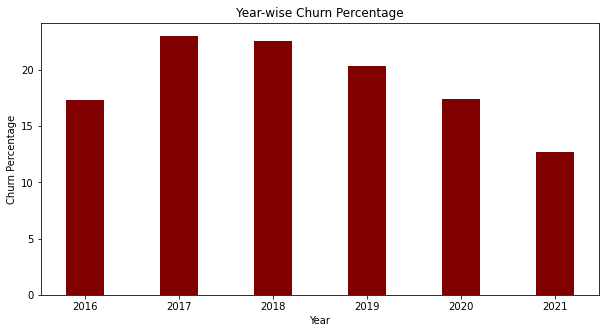

In [397]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(year_wise_churn['year'], year_wise_churn['Customer No'], color ='maroon',
        width = 0.4)
 
plt.xlabel("Year")
plt.ylabel("Churn Percentage")
plt.title("Year-wise Churn Percentage")
plt.show()

In [413]:
sales_consolidated.loc[(sales_consolidated['churn_standard'] == 1) & (sales_consolidated['last'] == 'true') & (sales_consolidated['Posting Date'] < '2021-04-01')  , ['Customer No']].nunique()/sales_consolidated['Customer No'].nunique()

Customer No    0.48395
dtype: float64

Checking distribution of how much time it takes to make another order for churn and non-churn customers

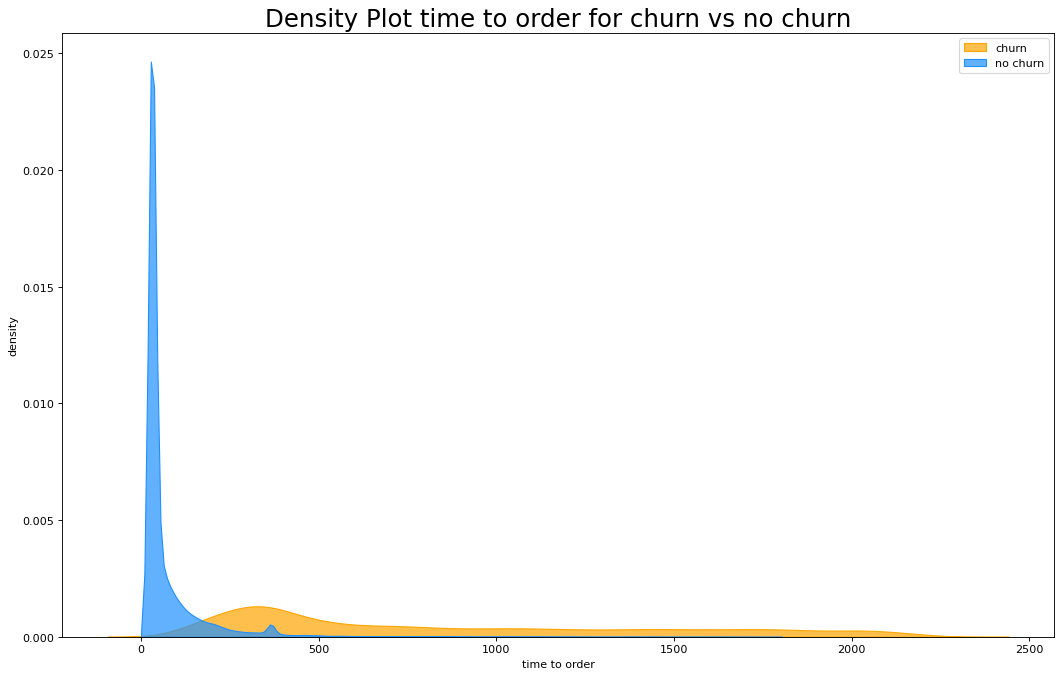

In [416]:

plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(sales_consolidated.loc[sales_consolidated['churn_standard'] == 1, "time_to_order"], shade=True, color="orange", label="churn", alpha=.7)
sns.kdeplot(sales_consolidated.loc[sales_consolidated['churn_standard'] == 0, "time_to_order"], shade=True, color="dodgerblue", label="no churn", alpha=.7)

# Decoration
plt.title('Density Plot time to order for churn vs no churn', fontsize=22)
plt.ylabel('density')
plt.xlabel('time to order')
plt.legend()
plt.show()

In [417]:
sales_consolidated.groupby('churn_standard')['time_to_order'].mean()

churn_standard
0.0     78.783705
1.0    862.878481
Name: time_to_order, dtype: float64

In [251]:
import statistics
statistics.stdev(sales_consolidated.loc[sales_consolidated['churn_standard'] == 0, "time_to_order"])

132.19681919691985

We need to test the hypothesis whether the amount spent per transaction has an impact on the time to order.

-0.022106686870308413

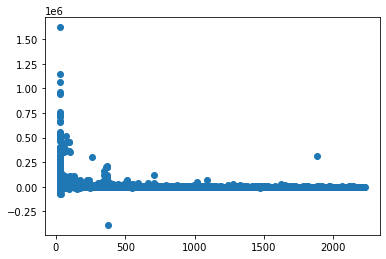

In [424]:
amount = sales_consolidated['Line Item Amount'].sub(sales_consolidated['Line Item Amount'].mean())
order_time = sales_consolidated['time_to_order'].sub(sales_consolidated['time_to_order'].mean())

plt.scatter(x = sales_consolidated['time_to_order'] , y = sales_consolidated['Line Item Amount'])

correlation = sales_consolidated['time_to_order'] .corr(sales_consolidated['Line Item Amount'])
correlation

There is no obvious trend or correlation between the two

## Account Data Merging with Sales

In [1196]:
account = pd.read_excel ('Data/Labelmaster Account Data.xlsx')

In [1197]:
account = account.rename(columns={"AccountNumber": "Customer No"})

Bringing extra accounts data information in consolidated data

In [291]:
sales_account = pd.merge(sales_consolidated,
                 account,
                 on='Customer No', 
                 how='left')
sales_account.isnull().mean() * 100 #Checking join percentage

customer_time                    0.000000
Quantity Ordered                 0.000000
Line Item Amount                 0.000000
Customer No                      0.000000
Posting Date                     0.000000
next_order_date                  0.000000
time_to_order                    0.000000
block                            0.000000
count                            0.000000
expected_purchase_window         0.000000
time_to_churn_standard           0.000000
churn_standard                   0.000000
last                            91.301042
year                             0.000000
time_to_churn_modified           0.000000
churn_modified                   0.000000
churn_score                      0.000000
churn alarm                      0.000000
Id                               0.001913
CreatedDate                      0.001913
LastActivityDate                28.560295
Coverage_Priority__c             0.001913
FamilyCode_FNT__c                0.001913
HQ_State__c                      6

Making customer wise table side by side

In [431]:
sales_consolidated_lasttransaction = sales_account.loc[sales_account['last'] == 'true']

### Churn Rate vs Tier 

In [459]:
tier_wise_churn_rate = sales_consolidated_lasttransaction.groupby(['year','Tier__c'])['churn_standard'].sum().reset_index()
tier_wise_churn = tier_wise_churn_rate.loc[(tier_wise_churn_rate.Tier__c != 'GOV')
                                                &(tier_wise_churn_rate.Tier__c != 'GOVCON')]

In [469]:
year_count = sales_account.groupby(['year','Tier__c'])['Customer No'].nunique().reset_index()
tier_wise_churn = pd.merge(tier_wise_churn,
                 year_count,
                 on=('year','Tier__c'), 
                 how='left')

tier_wise_churn['churn_rate'] = tier_wise_churn['churn_standard']/tier_wise_churn['Customer No']*100
tier_2020 = tier_wise_churn.loc[tier_wise_churn['year'] == 2020]
tier_2021 = tier_wise_churn.loc[tier_wise_churn['year'] == 2021]

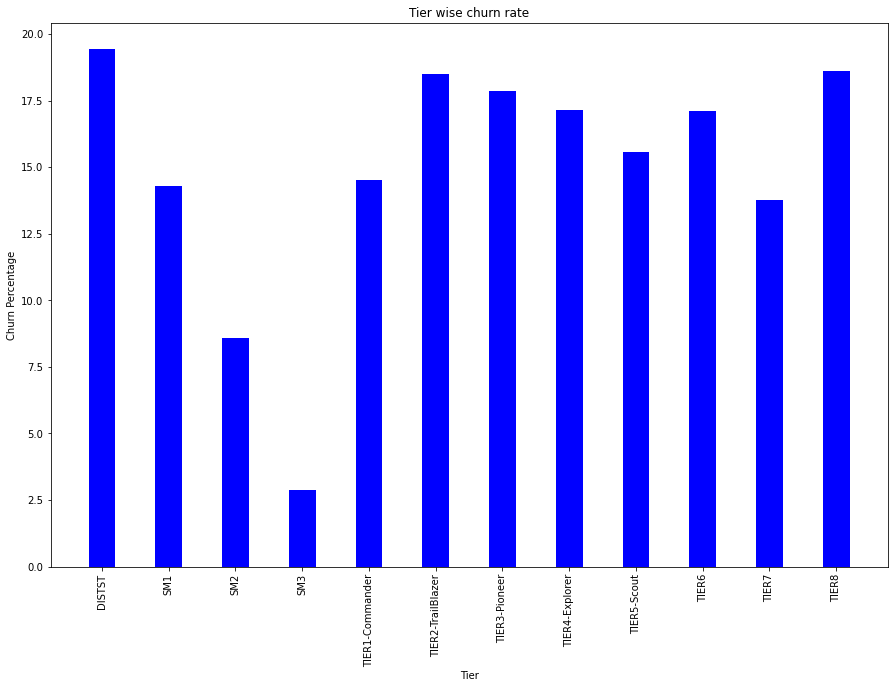

In [806]:
fig = plt.figure(figsize = (15, 10))

# creating the bar plot
plt.bar(tier_2020['Tier__c'], tier_2020['churn_rate'], color ='blue',
        width = 0.4)

plt.xticks(rotation=90)
plt.xlabel("Tier")
plt.ylabel("Churn Percentage")
plt.title("Tier wise churn rate")
plt.show()

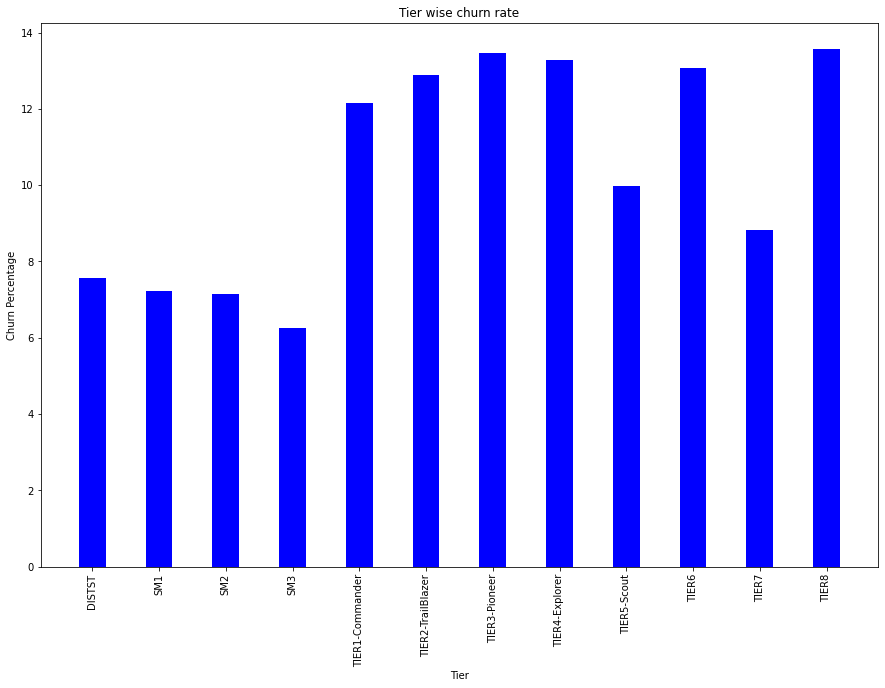

In [808]:
fig = plt.figure(figsize = (15, 10))

# creating the bar plot
plt.bar(tier_2021['Tier__c'], tier_2021['churn_rate'], color ='blue',
        width = 0.4)

plt.xticks(rotation=90)
plt.xlabel("Tier")
plt.ylabel("Churn Percentage")
plt.title("Tier wise churn rate")
plt.show()

The tier wise churn rate looks concerning and isn't what was expected. 

### Churn Rate vs Custom Client Revenue Ranges

Merging Company Revenue Ranges for better view

In [570]:
sales_account.loc[(sales_account['ZI_Company_Revenue_Range__c'] == 'Under $500,000') | (sales_account['ZI_Company_Revenue_Range__c'] == '$500,000 - $1 mil.'), 'Client_revenue'] = 'Under $1mil'
sales_account.loc[(sales_account['ZI_Company_Revenue_Range__c'] == '$1 mil. - $5 mil.') | (sales_account['ZI_Company_Revenue_Range__c'] == '$5 mil. - $10 mil.'), 'Client_revenue'] = '$1mil-$10mil'
sales_account.loc[(sales_account['ZI_Company_Revenue_Range__c'] == '$10 mil. - $25 mil.') | (sales_account['ZI_Company_Revenue_Range__c'] == '$25 mil. - $50 mil.')| (sales_account['ZI_Company_Revenue_Range__c'] == '$50 mil. - $100 mil.'), 'Client_revenue'] = '$10mil-$100mil'
sales_account.loc[(sales_account['ZI_Company_Revenue_Range__c'] == '$100 mil. - $250 mil.') | (sales_account['ZI_Company_Revenue_Range__c'] == '$250 mil. - $500 mil.'), 'Client_revenue'] = '$100mil-$500mil'
sales_account.loc[(sales_account['ZI_Company_Revenue_Range__c'] == '$500 mil. - $1 bil.'), 'Client_revenue'] = '$500mil-$1bil'
sales_account.loc[(sales_account['ZI_Company_Revenue_Range__c'] == 'Over $5 bil.'), 'Client_revenue'] = 'Over $5bil'


In [576]:
sales_consolidated_lasttransaction = sales_account.loc[sales_account['last'] == 'true']
Client_revenue = sales_consolidated_lasttransaction.groupby(['Client_revenue','year'])['churn_standard'].sum().reset_index()
year_count = sales_account.groupby(['year','Client_revenue'])['Customer No'].nunique().reset_index()

Client_revenue = pd.merge(Client_revenue,
                 year_count,
                 on=('year','Client_revenue'), 
                 how='left')

Client_revenue['churn_rate'] = Client_revenue['churn_standard']/Client_revenue['Customer No']*100

Client_revenue_2020 = Client_revenue.loc[Client_revenue['year'] == 2020]
Client_revenue_2021 = Client_revenue.loc[Client_revenue['year'] == 2021]

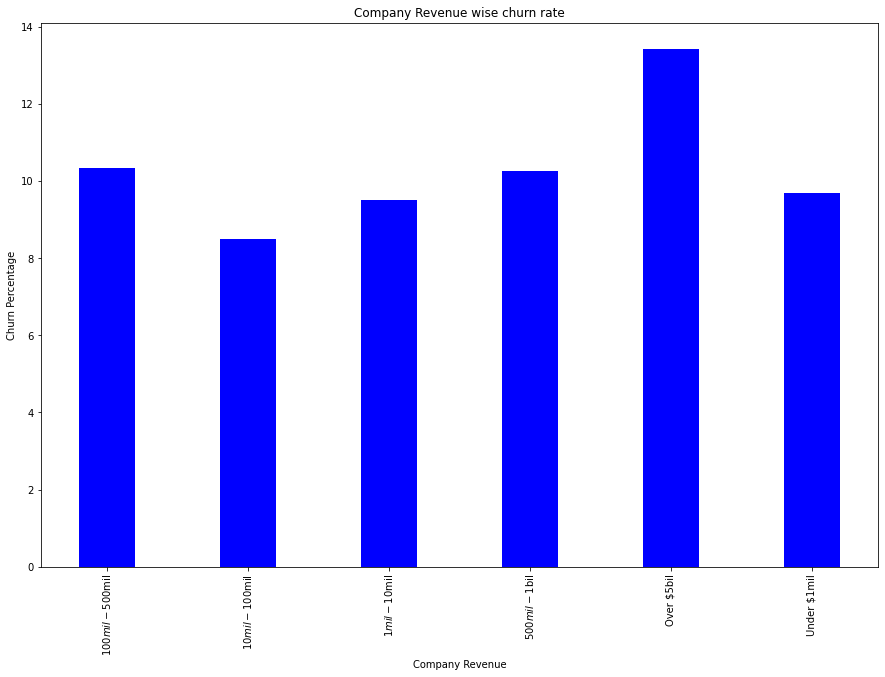

In [813]:
fig = plt.figure(figsize = (15, 10))

# creating the bar plot
plt.bar(Client_revenue_2021['Client_revenue'], Client_revenue_2021['churn_rate'], color ='blue',
        width = 0.4)

plt.xticks(rotation=90)
plt.xlabel("Company Revenue")
plt.ylabel("Churn Percentage")
plt.title("Company Revenue wise churn rate")
plt.show()

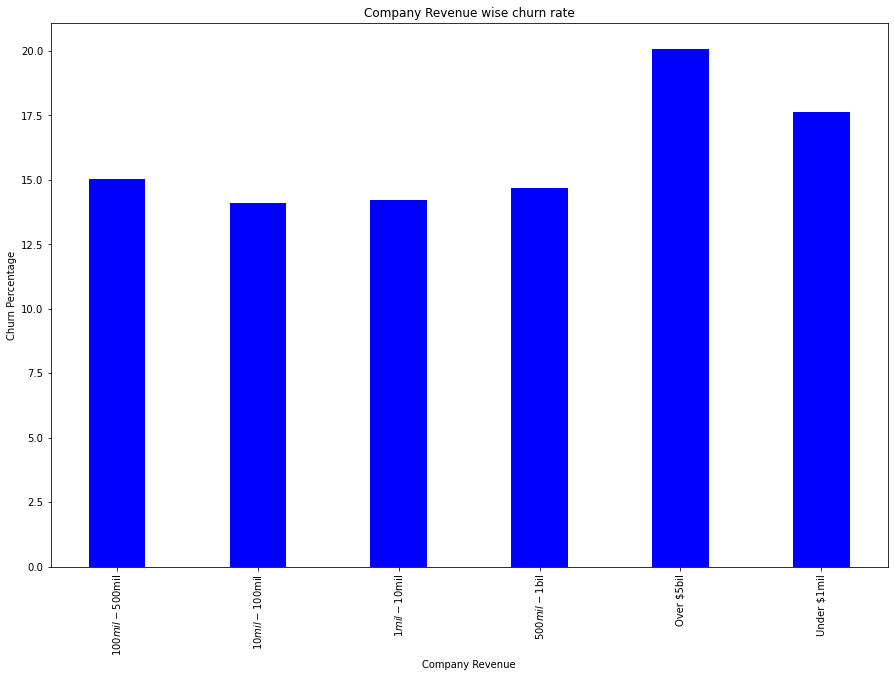

In [814]:
fig = plt.figure(figsize = (15, 10))

# creating the bar plot
plt.bar(Client_revenue_2020['Client_revenue'], Client_revenue_2020['churn_rate'], color ='blue',
        width = 0.4)

plt.xticks(rotation=90)
plt.xlabel("Company Revenue")
plt.ylabel("Churn Percentage")
plt.title("Company Revenue wise churn rate")
plt.show()

### Churn Rate vs CLV Buckets

Checking Churn Rate trend CLV wise and making CLV buckets

In [361]:
sales_account['cumulative_sum_revenue'] = sales_account.groupby('Customer No')['Line Item Amount'].cumsum()

sales_account.loc[(sales_account['cumulative_sum_revenue'] < 1000), 'revenue_bucket'] = 1
sales_account.loc[(sales_account['cumulative_sum_revenue'] >= 1000) & (sales_account['cumulative_sum_revenue'] < 2500), 'revenue_bucket'] = 2
sales_account.loc[(sales_account['cumulative_sum_revenue'] >= 2500) & (sales_account['cumulative_sum_revenue'] <= 5000), 'revenue_bucket'] = 3
sales_account.loc[(sales_account['cumulative_sum_revenue'] > 5000) & (sales_account['cumulative_sum_revenue'] <= 10000), 'revenue_bucket'] = 4                               
sales_account.loc[(sales_account['cumulative_sum_revenue'] > 10000), 'revenue_bucket'] = 5

In [524]:
sales_consolidated_lasttransaction = sales_account.loc[sales_account['last'] == 'true']
revenue_churn = sales_consolidated_lasttransaction.groupby(['revenue_bucket','year'])['churn_standard'].sum().reset_index()
year_count = sales_account.groupby(['year','revenue_bucket'])['Customer No'].nunique().reset_index()

revenue_churn = pd.merge(revenue_churn,
                 year_count,
                 on=('year','revenue_bucket'), 
                 how='left')

revenue_churn['churn_rate'] = revenue_churn['churn_standard']/revenue_churn['Customer No']*100

revenue_churn_2020 = revenue_churn.loc[revenue_churn['year'] == 2020]
revenue_churn_2021 = revenue_churn.loc[revenue_churn['year'] == 2021]

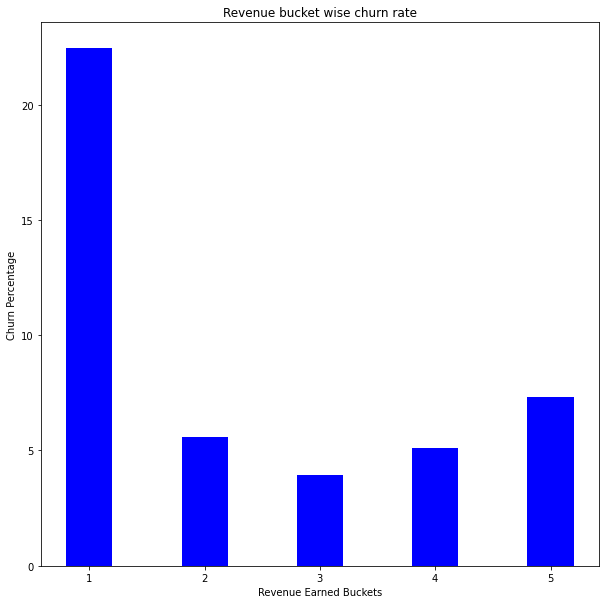

In [587]:
fig = plt.figure(figsize = (10, 10))

# creating the bar plot
plt.bar(revenue_churn_2021['revenue_bucket'], revenue_churn_2021['churn_rate'], color ='blue',
        width = 0.4)

plt.xlabel("Revenue Earned Buckets")
plt.ylabel("Churn Percentage")
plt.title("Revenue bucket wise churn rate")
plt.show()

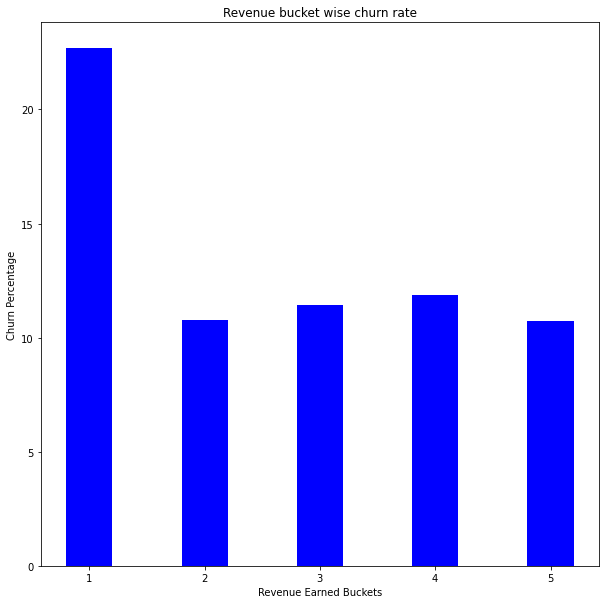

In [588]:
fig = plt.figure(figsize = (10, 10))

# creating the bar plot
plt.bar(revenue_churn_2020['revenue_bucket'], revenue_churn_2020['churn_rate'], color ='blue',
        width = 0.4)

plt.xlabel("Revenue Earned Buckets")
plt.ylabel("Churn Percentage")
plt.title("Revenue bucket wise churn rate")
plt.show()

### Churn Rate vs Number of Transactions

Checking Churn Rate as a function of number of transaction. 

In [607]:
labels_4 = ['first_quintile', 'second_quintile', 'third_quintile', 'fourth_quintile','fifth_quintile']
sales_account['count_group'] = pd.qcut(sales_account['count'],q=[0,0.2,0.4,0.6,0.8,1],labels=labels_4)

sales_consolidated_lasttransaction = sales_account.loc[sales_account['last'] == 'true']
count_churn = sales_consolidated_lasttransaction.groupby(['count_group','year'])['churn_standard'].sum().reset_index()
year_count = sales_account.groupby(['year','count_group'])['Customer No'].nunique().reset_index()

count_churn = pd.merge(count_churn,
                 year_count,
                 on=('year','count_group'), 
                 how='left')

count_churn['churn_rate'] = count_churn['churn_standard']/count_churn['Customer No']*100

count_churn2020 = count_churn.loc[count_churn['year'] == 2020]
count_churn2021 = count_churn.loc[count_churn['year'] == 2021]

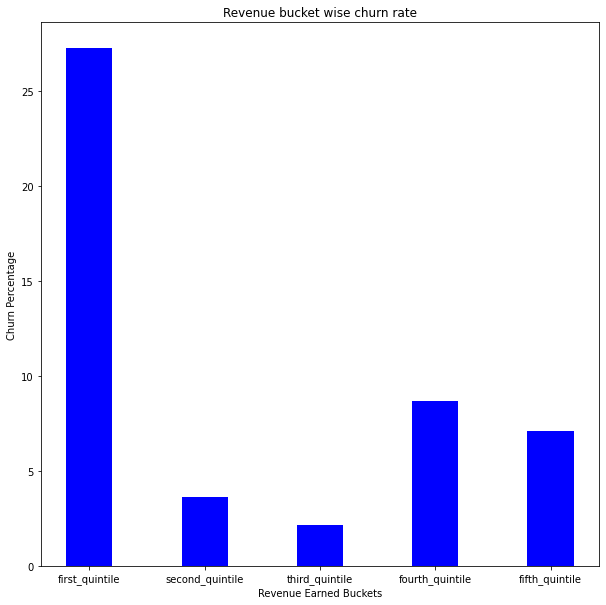

In [615]:
fig = plt.figure(figsize = (10, 10))

# creating the bar plot
plt.bar(count_churn2021['count_group'], count_churn2021['churn_rate'], color ='blue',
        width = 0.4)

plt.xlabel("Revenue Earned Buckets")
plt.ylabel("Churn Percentage")
plt.title("Revenue bucket wise churn rate")
plt.show()

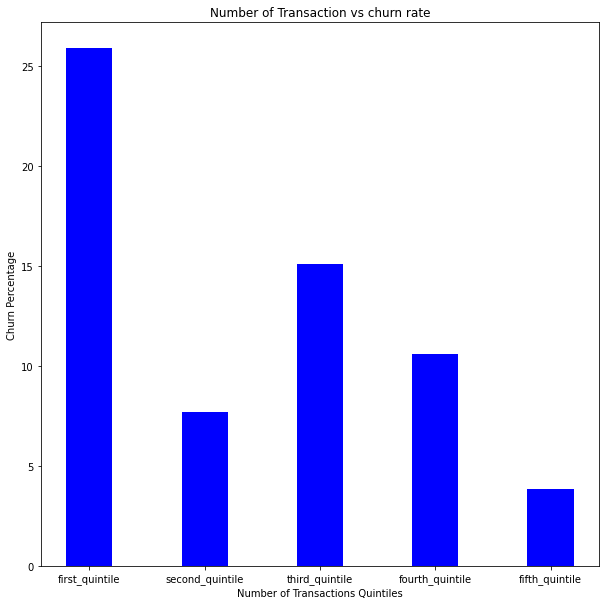

In [815]:
fig = plt.figure(figsize = (10, 10))

# creating the bar plot
plt.bar(count_churn2020['count_group'], count_churn2020['churn_rate'], color ='blue',
        width = 0.4)

plt.xlabel("Number of Transactions Quintiles")
plt.ylabel("Churn Percentage")
plt.title("Number of Transaction vs churn rate")
plt.show()

In [726]:
sales_account['Platinum_Quality_Ratio'] = (sales_account['total_platinum_items'])/((sales_account['total_platinum_items'])
                                                                                   +sales_account['total_gold_items']
                                                                                   +sales_account['total_silver_items']
                                                                                   +sales_account['total_Bronze_items']
                                                                                   +sales_account['total_Metal_items'])*100

sales_account['Platinum_Gold_Quality_Ratio'] = (sales_account['total_platinum_items']+sales_account['total_gold_items'])/((sales_account['total_platinum_items'])
                                                                                   +sales_account['total_gold_items']
                                                                                   +sales_account['total_silver_items']
                                                                                   +sales_account['total_Bronze_items']
                                                                                   +sales_account['total_Metal_items'])*100

sales_account['Platinum_Quality_Ratio'] = sales_account['Platinum_Quality_Ratio']*100
sales_account['Platinum_Gold_Quality_Ratio'] = sales_account['Platinum_Gold_Quality_Ratio']*100

sales_account.loc[sales_account['total_platinum_items'] == 0, 'Platinum_bucket'] = '0'
sales_account.loc[(sales_account['total_platinum_items'] >= 1) & (sales_account['total_platinum_items'] < 5), 'Platinum_bucket'] = '1-5'
sales_account.loc[(sales_account['total_platinum_items'] >= 5), 'Platinum_bucket'] = '>5'

sales_consolidated_lasttransaction = sales_account.loc[(sales_account['last'] == 'true')]

In [819]:
platinum_churn = sales_consolidated_lasttransaction.groupby(['Platinum_bucket','year'])['churn_standard'].sum().reset_index()
year_count = sales_account.groupby(['year','Platinum_bucket'])['Customer No'].nunique().reset_index()

platinum_churn = pd.merge(platinum_churn,
                 year_count,
                 on=('year','Platinum_bucket'), 
                 how='left')

platinum_churn['churn_rate'] = platinum_churn['churn_standard']/platinum_churn['Customer No']*100

platinum_churn_2021 = platinum_churn.loc[platinum_churn['year'] == 2021]

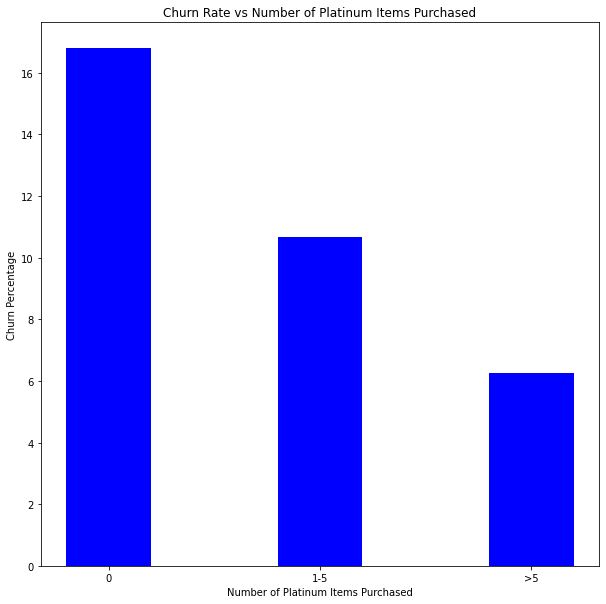

In [824]:
fig = plt.figure(figsize = (10, 10))

# creating the bar plot
plt.bar(platinum_churn_2021['Platinum_bucket'], platinum_churn_2021['churn_rate'], color ='blue',
        width = 0.4)

plt.xlabel("Number of Platinum Items Purchased")
plt.ylabel("Churn Percentage")
plt.title("Churn Rate vs Number of Platinum Items Purchased")
plt.show()

In [796]:
sales_account.loc[sales_account['Platinum_Quality_Ratio'] == 0, 'Platinum_Quality_bucket'] = '0'
sales_account.loc[(sales_account['Platinum_Quality_Ratio'] >= 1) & (sales_account['Platinum_Quality_Ratio'] < 25), 'Platinum_Quality_bucket'] = '1-25'
sales_account.loc[(sales_account['Platinum_Quality_Ratio'] >= 25) & (sales_account['Platinum_Quality_Ratio'] <= 100), 'Platinum_Quality_bucket'] = '>25'

sales_consolidated_lasttransaction = sales_account.loc[(sales_account['last'] == 'true')]

In [804]:
platinum_churn = sales_consolidated_lasttransaction.groupby(['Platinum_Quality_bucket','year'])['churn_standard'].sum().reset_index()
year_count = sales_account.groupby(['year','Platinum_Quality_bucket'])['Customer No'].nunique().reset_index()
platinum_churn = pd.merge(platinum_churn,
                 year_count,
                 on=('year','Platinum_Quality_bucket'), 
                 how='left')

platinum_churn['churn_rate'] = platinum_churn['churn_standard']/platinum_churn['Customer No']*100

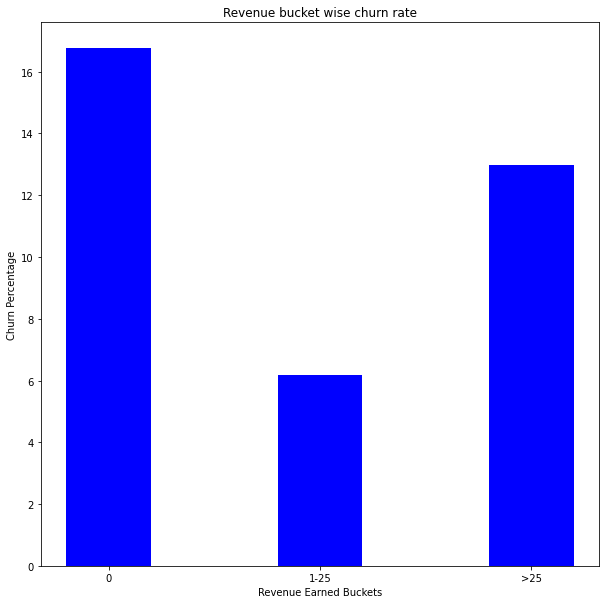

In [805]:
platinum_churn_2021 = platinum_churn.loc[platinum_churn['year'] == 2021]
fig = plt.figure(figsize = (10, 10))

# creating the bar plot
plt.bar(platinum_churn_2021['Platinum_Quality_bucket'], platinum_churn_2021['churn_rate'], color ='blue',
        width = 0.4)

plt.xlabel("Revenue Earned Buckets")
plt.ylabel("Churn Percentage")
plt.title("Revenue bucket wise churn rate")
plt.show()

##### Creating tenure feature

In [841]:
first_sale = sales_account.loc[sales_account['count'] == 1][['Customer No','Posting Date']]
first_sale = first_sale.rename(columns={"Posting Date": "first_sale_date"})
sales_account = pd.merge(sales_account,
                 first_sale,
                 on=('Customer No'), 
                 how='left')

sales_account['tenure'] = sales_account['Posting Date'] - sales_account['first_sale_date']
sales_account['tenure'] = sales_account['tenure']/np.timedelta64(1,'D')

sales_consolidated_lasttransaction = sales_account.loc[(sales_account['last'] == 'true')]

In [849]:
sales_consolidated_lasttransaction.groupby('churn_standard')['tenure'].mean()

churn_standard
0.0    1289.108969
1.0     328.219767
Name: tenure, dtype: float64

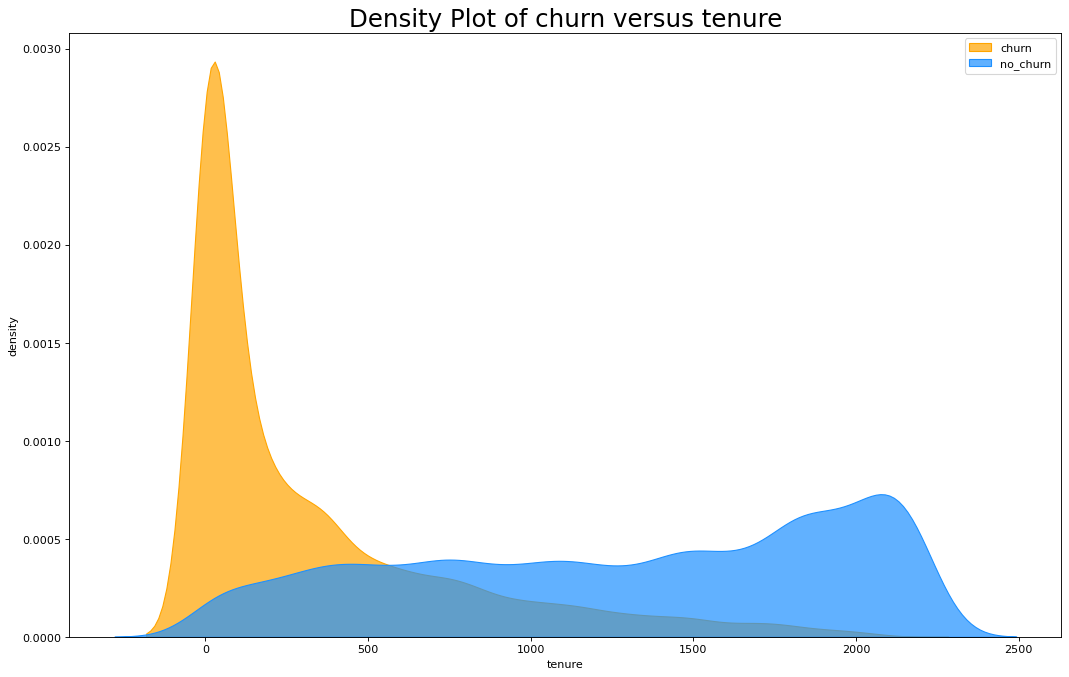

In [850]:
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(sales_consolidated_lasttransaction.loc[sales_consolidated_lasttransaction['churn_standard'] == 1, "tenure"], shade=True, color="orange", label="churn", alpha=.7)
sns.kdeplot(sales_consolidated_lasttransaction.loc[sales_consolidated_lasttransaction['churn_standard'] == 0, "tenure"], shade=True, color="dodgerblue", label="no_churn", alpha=.7)

# Decoration
plt.title('Density Plot of churn versus tenure', fontsize=22)
plt.ylabel('density')
plt.xlabel('tenure')
plt.legend()
plt.show()

Churned customers have a very less tenure. Non-churned customers have much larger tenure

### Incorporating Different Features

In [1152]:
#Master data set for features
features = sales_account
features.head(5)

,customer_time,Quantity Ordered,Line Item Amount,Customer No,Posting Date,next_order_date,time_to_order,block,count,expected_purchase_window,...,total_silver_items,total_Bronze_items,total_Metal_items,Platinum_Quality_Ratio,Platinum_Gold_Quality_Ratio,Platinum_bucket,Platinum_Quality_bucket,first_sale_date,tenure,AvgCost
0,00000012016-11-04,9,258.77,0000001,2016-11-04,2016-11-17 00:00:00.000000,30.0000,1,1,60.0,...,0.0,0.0,0.0,100.0,100.0,1-5,>25,2016-11-04,0.0,258.770000
1,00000012016-11-17,-9,-258.77,0000001,2016-11-17,2022-02-09 13:56:03.802254,1910.5806,1,2,30.0,...,0.0,0.0,1.0,50.0,50.0,1-5,>25,2016-11-04,13.0,0.000000
2,00000102016-04-27,3,138.70,0000010,2016-04-27,2016-06-08 00:00:00.000000,42.0000,2,1,60.0,...,1.0,0.0,0.0,0.0,0.0,0,0,2016-04-27,0.0,138.700000
3,00000102016-06-08,3,56.73,0000010,2016-06-08,2016-07-29 00:00:00.000000,51.0000,2,2,42.0,...,1.0,0.0,0.0,0.0,50.0,0,0,2016-04-27,42.0,97.715000
4,00000102016-07-29,5,289.80,0000010,2016-07-29,2016-10-18 00:00:00.000000,81.0000,2,3,46.5,...,2.0,1.0,0.0,0.0,25.0,0,0,2016-04-27,93.0,161.743333


##### Average Quantity Ordered, Total Quantity, Gradient Quantity, Total Cost and Average Cost

In [1153]:
#1- Average Quantity of items ordered by the customer
features['AvgQuantity'] = (
    features.groupby('Customer No')['Quantity Ordered'].apply(lambda x: x.expanding().mean()))

#2- Total number of items purchased by the customer till date
features['TotalQuantity'] = (
    features.groupby('Customer No')['Quantity Ordered'].cumsum())

#3- Gradient of the number of products ordered by customer
features['GradientQuantity'] = (
    features.groupby('Customer No')['Quantity Ordered'].diff())

#5- Total revenue generated by the customer to date/ CLV
features['TotalCost'] = (
    features.groupby('Customer No')['Line Item Amount'].cumsum())

#6- Average revenue of the customer (Line amount/total orders) 
features['AvgCost'] = (
    features.groupby('Customer No')['Line Item Amount'].apply(lambda x: x.expanding().mean()))

##### Net Purchasing Interval Increasing or Decreasing Variable

In [1372]:
sales_account.loc[sales_account['Customer No'] == sales_account['Customer No'].shift(1),'last_order_date'] = sales_account['Posting Date'].shift(1) 

sales_account['time_between_sales_trend'] = sales_account['Posting Date'] - sales_account['last_order_date']

sales_account['time_between_sales_trend'] = sales_account['time_between_sales_trend']/np.timedelta64(1,'D')

sales_account['time_between_sales_trend'] = (
    sales_account.groupby('Customer No')['time_between_sales_trend'].diff())

sales_account['time_between_sales_trend'] = (
    sales_account.groupby('Customer No')['time_between_sales_trend'].cumsum())

##### Net Sales Revenue Increasing or Decreasing

In [1335]:
sales_account['Gradient_Revenue'] = (
    features.groupby('Customer No')['Line Item Amount'].diff())
sales_account['Gradient_Revenue'] = (
    sales_account.groupby('Customer No')['Gradient_Revenue'].cumsum())

sales_account[(sales_account['Gradient_Revenue'] < -50000) & (sales_account['last'] == 'true')]

In [1417]:
sales_account[["Gradient_Revenue", "time_between_sales_trend"]].describe()

,Gradient_Revenue,time_between_sales_trend
count,381894.000000,345508.000000
mean,-88.761105,1.428517
std,8913.396287,166.301134
min,-673743.610000,-2043.000000
25%,-209.990000,-17.000000
50%,0.870000,0.000000
75%,216.130000,21.000000
max,948345.300000,2072.000000


##### Customer Specific top Items

In [1188]:
# Customer Specific top Items
x=pd.DataFrame(sales.groupby(['Customer No'])['Item'].value_counts().rename('Count').reset_index()) 
x= x.drop_duplicates('Customer No')
features =pd.merge(features, x, on=('Customer No'), how='left')
features = features.rename(columns={'Item':'Customer_specific_pop.Item', 'Count':'Popular_item_count'})
sales_account = features

##### No. of Managers & Consolidated Silverpop score

In [1209]:
contact1 = pd.read_excel (r'/Users/areeb/Downloads/contact_features.xlsx')
contact1 = contact1.rename(columns={"AccountNumber": "Customer No"})
contact1 = contact1[['Customer No','No.Of Managers','Consolidated_Silverpop']]

sales_account = pd.merge(sales_account,
                 contact1,
                 on=('Customer No'), 
                 how='left')

##### Percent DGOP contacts

In [1218]:
contact = pd.read_excel (r'/Users/areeb/Downloads/contact.xlsx')


In [1222]:
contact2 = contact.groupby('Acct_Number__c').agg(NoofContacts_DGOP=('Job_Function_LM__c', 'value_counts')).reset_index()
contact3=contact2.groupby('Acct_Number__c').agg(TotalContacts=('NoofContacts_DGOP', 'sum')).reset_index()
contact_DGOP=contact2.loc[(contact2['Job_Function_LM__c']=="DG") | (contact2['Job_Function_LM__c']=="OP")]
contact_DGOP=contact_DGOP.groupby('Acct_Number__c').agg(Total_DGOP_Contacts=('NoofContacts_DGOP', 'sum')).reset_index()
contact_DGOP=contact_DGOP.merge(contact3,on=('Acct_Number__c'),how=('left'))
contact_DGOP['Perc_DGOP']=((contact_DGOP['Total_DGOP_Contacts'])/(contact_DGOP['TotalContacts'])*100)

sales_account = sales_account.merge(contact_DGOP,left_on=('Customer No'),right_on=('Acct_Number__c'),how=('left'))

##### Compliance score of family and family data join with sales_account

In [1258]:
family = pd.read_excel (r'/Users/areeb/Downloads/family.xlsx')
#sales_account = sales_account.merge(contact_DGOP,left_on=('Customer No'),right_on=('Acct_Number__c'),how=('left'))

In [1261]:
family['Family_Name__c'] = family['Family_Name__c'].astype(str)
family['Family_Segmentation__c'] = family['Family_Segmentation__c'].fillna('not_compliant')
sub ='Safely'
sub2 = 'Basically'
sub3 = 'not_compliant'
family.loc[family["Family_Segmentation__c"].str.contains(sub),'compliance_score'] = 1
family.loc[family["Family_Segmentation__c"].str.contains(sub2),'compliance_score'] = 2
family.loc[family["Family_Segmentation__c"].str.contains(sub3),'compliance_score'] = 3
del family['Tier_Note__c']

sales_account['family_code'] = sales_account['FamilyCode_FNT__c'].astype(str).str.split('.').str[0]
sales_account = sales_account.merge(family,left_on=('family_code'),right_on=('Family_Name__c'),how=('left'))

In [1323]:
del sales_account['ZI_Industry__c']
industry = account[['Customer No','ZI_Industry__c']]
sales_account = sales_account.merge(industry,left_on=('Customer No'),right_on=('Customer No'),how=('left'))
sales_account.loc[sales_account['ZI_Industry__c'].isnull(),'ZI_Industry__c'] = sales_account['Family_Industry_Description_New__c']

sales_consolidated_lasttransaction = sales_account.loc[(sales_account['last'] == 'true')]

##### Item Diversity Index and Dept Diversity Index

In [1436]:
sales_item = sales.groupby(['customer_time'])['Item'].nunique().reset_index()
sales_dept = sales.groupby('customer_time')['Department Dim Description'].nunique().reset_index()

sales_item = sales_item.rename(columns={'Item': "item_diversity_index"})
sales_dept = sales_dept.rename(columns={'Department Dim Description': "dept_diversity_index"})

sales_account = sales_account.merge(sales_item, on = ('customer_time'),how=('left'))
sales_account = sales_account.merge(sales_dept, on = ('customer_time'),how=('left'))


sales_account['cumulative_item_count'] = sales_account.groupby('Customer No')['item_diversity_index'].cumsum()
sales_account['cumulative_dept_count'] = sales_account.groupby('Customer No')['dept_diversity_index'].cumsum()


sales_account['item_diversity_index'] = sales_account['cumulative_item_count']/sales_account['count']
sales_account['dept_diversity_index'] = sales_account['cumulative_dept_count']/sales_account['count']


sales_account.drop(['cumulative_item_count', 'cumulative_dept_count'], axis=1, inplace=True)

In [1450]:
sales_account.columns

Index(['customer_time', 'Quantity Ordered', 'Line Item Amount', 'Customer No',
       'Posting Date', 'next_order_date', 'time_to_order', 'block', 'count',
       'expected_purchase_window', 'time_to_churn_standard', 'churn_standard',
       'last', 'year', 'time_to_churn_modified', 'churn_modified',
       'churn_score', 'churn alarm', 'Id_x', 'CreatedDate_x',
       'LastActivityDate', 'Coverage_Priority__c', 'FamilyCode_FNT__c',
       'HQ_State__c', 'ZI_Company_Revenue_Range__c', 'ZI_Company_Ranking__c',
       'ZI_Company_Employee_Range__c', 'Tier__c', 'ZI_Company_Type__c',
       'ZI_Number_Of_Locations__c', 'ZI_Technologies__c',
       'cumulative_sum_revenue', 'revenue_bucket', 'Client_revenue',
       'count_group', 'Platinum_products', 'Gold_products', 'Silver_products',
       'Bronze_products', 'Metal_products', 'total_platinum_items',
       'total_gold_items', 'total_silver_items', 'total_Bronze_items',
       'total_Metal_items', 'Platinum_Quality_Ratio',
       'Platinu

In [1464]:
IIT_churn_master_dataset = sales_account
IIT_churn_customer_master_dataset = sales_consolidated_lasttransaction

IIT_churn_master_dataset = IIT_churn_master_dataset.drop(['Quantity Ordered','Line Item Amount','next_order_date','block',
                       'last','year','Id_x','CreatedDate_x','LastActivityDate','FamilyCode_FNT__c','count_group',
                       'Platinum_products','Gold_products','Silver_products','Bronze_products','Metal_products',
                       'first_sale_date','GradientQuantity','Acct_Number__c','family_code','Id_y','CreatedDate_y',
                       'Family_Name__c','last_order_date'],axis = 1)
IIT_churn_customer_master_dataset = IIT_churn_customer_master_dataset.drop(['customer_time','Quantity Ordered','Line Item Amount','next_order_date','block',
                       'last','year','Id_x','CreatedDate_x','LastActivityDate','FamilyCode_FNT__c','count_group',
                       'Platinum_products','Gold_products','Silver_products','Bronze_products','Metal_products',
                       'first_sale_date','GradientQuantity','Acct_Number__c','family_code','Id_y','CreatedDate_y',
                       'Family_Name__c','last_order_date'],axis = 1)

# Final Dataset for Modeling Transaction Wise

In [1463]:
IIT_churn_master_dataset.to_excel("IIT_churn_master_dataset.xlsx")  

# Final Dataset for Customer Wise

In [1465]:
IIT_churn_customer_master_dataset.to_excel("IIT_churn_customer_master_dataset.xlsx")  

### Department Dim Analysis

In [997]:
sales.loc[(sales['Department Dim Description'] == 'Placards') | (sales['Department Dim Description'] == 'Imprinted Placards'),'Department Dim Description'] = 'Placards'
sales.loc[(sales['Department Dim Description'] == 'Labels') | (sales['Department Dim Description'] == 'Personal Compliance'),'Department Dim Description'] = 'Labels & PC'

#del sales['churn_standard']

sales = sales.set_index('Customer No')

sales_account_sub = sales_consolidated_lasttransaction[['Customer No','churn_standard']]
sales = pd.merge(sales,
                 sales_account_sub,
                 on=('Customer No'), 
                 how='left')


sales_filter = sales.loc[sales['item_type'].notnull()]
sales_filter = sales_filter[sales_filter['churn_standard'].notnull()]

sales_filter = sales_filter.groupby(['Customer No','Department Dim Description','year'])['churn_standard'].max().reset_index()

item_top_churn = sales_filter.groupby(['Department Dim Description','year','churn_standard']).size().sort_values(ascending = False).reset_index()

item_top_churn = item_top_churn.rename(columns={0: "count"})
item_top_churn_0 = item_top_churn.loc[item_top_churn['churn_standard'] == 0]
item_top_churn_1 = item_top_churn.loc[item_top_churn['churn_standard'] == 1]
item_top_churn = pd.merge(item_top_churn_0,
                 item_top_churn_1,
                 on=('Department Dim Description','year'), 
                 how='left')

item_top_churn['churn_rate'] = item_top_churn['count_y']/(item_top_churn['count_y']+item_top_churn['count_x'])

In [1013]:
sales_filter = sales.loc[sales['item_type'].notnull()]
sales_filter = sales_filter[sales_filter['churn_standard'].notnull()]


##### Dept and Industry wise churn

In [1075]:
sales_consolidated_lasttransaction.loc[(sales_consolidated_lasttransaction['ZI_Industry__c']!= 'Manufacturing')&
                 (sales_consolidated_lasttransaction['ZI_Industry__c']!= 'Business Services')&
                 (sales_consolidated_lasttransaction['ZI_Industry__c']!= 'Energy, Utilities & Waste')&
                 (sales_consolidated_lasttransaction['ZI_Industry__c']!= 'Retail')&
                 (sales_consolidated_lasttransaction['ZI_Industry__c']!= 'Transportation'),'ZI_Industry__c'] = 'Other'

industry_wise_churn = sales_consolidated_lasttransaction.groupby(['year','ZI_Industry__c'])['churn_standard'].sum().reset_index()

sales_account.loc[(sales_account['ZI_Industry__c']!= 'Manufacturing')&
                 (sales_account['ZI_Industry__c']!= 'Business Services')&
                 (sales_account['ZI_Industry__c']!= 'Energy, Utilities & Waste')&
                 (sales_account['ZI_Industry__c']!= 'Retail')&
                 (sales_account['ZI_Industry__c']!= 'Transportation'),'ZI_Industry__c'] = 'Other'
year_count = sales_account.groupby(['year','ZI_Industry__c'])['Customer No'].nunique().reset_index()

industry_wise_churn = pd.merge(industry_wise_churn,
                 year_count,
                 on=('year','ZI_Industry__c'), 
                 how='left')

industry_wise_churn['churn_rate'] = industry_wise_churn['churn_standard']/industry_wise_churn['Customer No']*100

C:\Users\areeb\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [1052]:
customer_indus = sales_consolidated_lasttransaction[['Customer No','ZI_Industry__c']]
customer_indus.loc[(customer_indus['ZI_Industry__c']!= 'Manufacturing')&
                 (customer_indus['ZI_Industry__c']!= 'Business Services')&
                 (customer_indus['ZI_Industry__c']!= 'Energy, Utilities & Waste')&
                 (customer_indus['ZI_Industry__c']!= 'Retail')&
                 (customer_indus['ZI_Industry__c']!= 'Transportation'),'ZI_Industry__c'] = 'Other'

C:\Users\areeb\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\areeb\anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [1056]:
sales_filter = pd.merge(sales_filter,
                 customer_indus,
                 on=('Customer No'), 
                 how='left')

sales_filter2 = sales_filter.groupby(['Customer No','Department Dim Description','year','ZI_Industry__c'])['churn_standard'].max().reset_index()
sales_filter2 = sales_filter2.groupby(['ZI_Industry__c','Department Dim Description','year','churn_standard']).size().sort_values(ascending = False).reset_index()

In [1060]:
sales_filter2 = sales_filter2.rename(columns={0: "count"})
sales_filter2_0 = sales_filter2.loc[sales_filter2['churn_standard'] == 0]
sales_filter2_1 = sales_filter2.loc[sales_filter2['churn_standard'] == 1]
sales_filter2 = pd.merge(sales_filter2_0,
                 sales_filter2_1,
                 on=('Department Dim Description','ZI_Industry__c','year'), 
                 how='left')

sales_filter2 = sales_filter2[sales_filter2['count_x'] > 100]
sales_filter2['churn_rate'] = sales_filter2['count_y']/(sales_filter2['count_y']+sales_filter2['count_x'])

## Baker & PPG Case Study

In [1131]:
baker = sales_consolidated_lasttransaction[sales_consolidated_lasttransaction['Customer No'] == '3001522'][['Customer No','Posting Date','Platinum_products','Gold_products','Silver_products','Bronze_products','Metal_products','time_to_order','expected_purchase_window','time_to_churn_standard','tenure','churn_standard']]
baker

In [1151]:
sales2.loc[(sales2['Customer No'] == '3001522') & (sales2['Posting Date'] == '2020-02-11')]

,Customer No,Item,Quantity Ordered,Line Item Amount,Posting Date,Ship-to State,Ship-to ZipCode,Department Dim,Department Dim Description,Product Group Code,Product Group Description,Order Method,Location Code
791542,3001522,ZEZ21993,8,218.32,2020-02-11,TX,75662,511,Placards,51111,Pre-Printed Placards,LM-WEB,10
791543,3001522,L701,5,138.35,2020-02-11,TX,75662,503,Labels,50303,Regulatory Markings,LM-WEB,10
791544,3001522,ZEZ43265,6,163.74,2020-02-11,TX,75662,511,Placards,51111,Pre-Printed Placards,LM-WEB,10
791545,3001522,Z-EZ2,12,264.48,2020-02-11,TX,75662,511,Placards,51102,Worded Placards,LM-WEB,10
791546,3001522,SHIPPING,1,45.58,2020-02-11,TX,75662,699,Contra Dimension,NaN,NaN,LM-WEB,10


In [1140]:
ppg = sales_consolidated_lasttransaction[sales_consolidated_lasttransaction['Customer No'] == '1268833'][['Customer No','Posting Date','Platinum_products','Gold_products','Silver_products','Bronze_products','Metal_products','time_to_order','expected_purchase_window','time_to_churn_standard','tenure','churn_standard']]
ppg

In [1143]:
ppg

,Customer No,Posting Date,Platinum_products,Gold_products,Silver_products,Bronze_products,Metal_products,time_to_order,expected_purchase_window,time_to_churn_standard,tenure,churn_standard
238197,1268833,2021-09-16,2.0,0.0,1.0,2.0,1.0,146.5806,30.111111,120.444444,2081.0,1.0


In [1145]:
sales_account.loc[(sales_account['Customer No'] == '1268833') & (sales_account['time_to_order'] > 70)]

,customer_time,Quantity Ordered,Line Item Amount,Customer No,Posting Date,next_order_date,time_to_order,block,count,expected_purchase_window,...,total_silver_items,total_Bronze_items,total_Metal_items,Platinum_Quality_Ratio,Platinum_Gold_Quality_Ratio,Platinum_bucket,Platinum_Quality_bucket,first_sale_date,tenure,AvgCost
238194,12688332021-05-27,2,259.01,1268833,2021-05-27,2021-08-30 00:00:00.000000,95.0000,11803,835,30.033573,...,527.0,302.0,822.0,21.212121,35.858586,>5,1-25,2016-01-05,1969.0,813.143677
238197,12688332021-09-16,3,0.00,1268833,2021-09-16,2022-02-09 13:56:03.802254,146.5806,11803,838,30.111111,...,528.0,307.0,824.0,21.268368,35.846868,>5,1-25,2016-01-05,2081.0,811.690346
